# Reaction coordinates of the Alanine dipeptide

We now demonstrate how to compute reaction coordinates of a small biomolecule based on long-time trajectory data.
Specifically, we analyze the Alanine dipeptide, a small biomolecule commonly used as a first test system for computational methods in molecular dynamics. For details on the mathematical theory behind the trajectory-based transition manifold method, as well as more information about the molecular system, see https://doi.org/10.1063/1.5035183.

![render](data/Aladipep_render.png)

(Image source: https://arxiv.org/abs/1904.08622)

In this notebook, you will learn how to
- import the trajectory data used for the machine learning method
- apply the kernel embedding variant of the transition manifold method to the trajectory data
- interpret the computed reaction coordinate in the context of molecular conformation dynamics

First we import the necessary external modules, as well as the TMRC modules.

In [1]:
# Generic imports
import sys
import os
from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(0)

# Numerics imports
import numpy as np
from sklearn.cluster import MiniBatchKMeans

# Visualization imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Tell python where to find the TMRC package
sys.path.insert(0,'../..')

# Import TMRC modules
import tram.system as dynsys
import tram.kernels as krnls
import tram.transition_manifold as tm
import tram.embedding_functions as emb

### System description and data import

The Alanine dipeptide consists of 22 Atoms, including hydrogen. Hence, when considering only the three-dimensional Cartesian coordinates of the atom's position over time, the dynamical system for this molecule is 66-dimensional.

It is well-known that the essential dynamical behavior of this molecule can be described reasonably accurate by changes in two central dihedral backbone angles, indicated in the picture above by $\varphi$ and $\psi$. 
When plotting the Ramachandran plot of these two angles, which corresponds to the free energy surface in these two coordinates, one can see four clusters of points, that correspond to four metastable configurations of the molecule:

![ramachandran](data/Aladipep_ramachandran.png)

(Image source: https://arxiv.org/abs/1904.08622)

We will investigate whether the transition manifold method can recover reaction coordinates that describe the transitions between these conformations. However, no knowledge about the existence of these essential dihedral angles is used in the computation; the method will be applied the full 66-dimensional data.

The dynamical data on which our computations will be based comes from a 40 ns long [Gromacs](http://www.gromacs.org) simulation of a single alanine dipeptide molecule in aqueous solution at temperature 400K. For details on the simulation setup, see  https://doi.org/10.1063/1.5035183

For this demonstration, we subsampled the original simulation every 0.2 ps, resulting in a total of 200000 frames. The data is saved in the NumPy array `trajdata.npy` which is provided with this notebook. The following command loads the data.

In [3]:
X = np.load('data/trajdata.npz')['X']
np.shape(X)

(200000, 66)

Next we construct test points in the state space $\mathbb{R}^{66}$ that will serve as the evaluation points for the final reaction coordiante. The test points need to evenly cover the area sampled by the trajectory. To achieve this, we apply the k-means clustering algorithm with a large number of clusters k to the points in the trajectory, and use the cluster centers as the test points, as the centers will be naturally spread out across the data. Specifically, we use the `MiniBatchKMeans` implementation of `sklearn`, which performs faster on long trajectories.

In [4]:
# number of test points
ntest = 1000

mbkm = MiniBatchKMeans(n_clusters=ntest)
mbkm.fit(X) # cluster the trajectory data
xtest = mbkm.cluster_centers_

While we cannot show the distribution of the test points in $\mathbb{R}^{66}$, we can compute their dihedral angles $\varphi$ and $\psi$ and show their distribution in the dihedral angle space. To compute the dihedrals, the `BioPython` package was used. In the plot below, we see that each of the four conformations contains at least some test points.

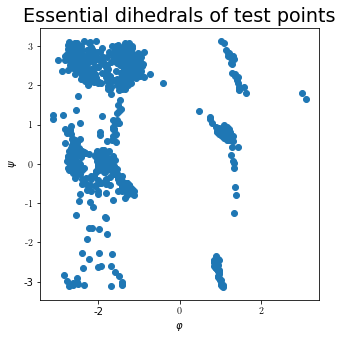

In [5]:
# import BioPython methods and data structures
from Bio.PDB.vectors import calc_dihedral
from Bio.PDB.vectors import Vector

# compute dihredral angles for every test point
phi = np.zeros(1000)
psi = np.zeros(1000)
for i in range(1000):
    v1 = Vector(xtest[i,12],xtest[i,13],xtest[i,14])
    v2 = Vector(xtest[i,18],xtest[i,19],xtest[i,20])
    v3 = Vector(xtest[i,24],xtest[i,25],xtest[i,26])
    v4 = Vector(xtest[i,42],xtest[i,43],xtest[i,44])
    v5 = Vector(xtest[i,48],xtest[i,49],xtest[i,50])
    phi[i] = calc_dihedral(v1,v2,v3,v4)
    psi[i] = calc_dihedral(v2,v3,v4,v5)
    
# visualize dihedral distribution
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(phi, psi, marker='o')

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 16}
plt.rc('font', **font)
fig.set_size_inches(5,5)
ax.set_title(r'Essential dihedrals of test points')
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\psi$')
plt.show()

### Manifold learning

Next, the transition manifold and its parameters are set up.

Internally, again the transition density function associated with each test point is approximated from the trajectory data. The lag time of these transition densities again needs to fall between the slow and the fast time scales. A lag time of 20 ps has proved adequate empirically, which with a step size of 0.2 ps corresponds to 100 steps in the trajectory.

For measuring the distance between the transition densities, we use the kernel embedding method due to its superior stability. Specifically, we use the Gaussian kernel with bandwidth $\sigma=10$.

We can then instantiate the transition manifold as a `KernelTrajTransitionManifold` object.

In [6]:
system = None # we do not have an explicitly-defined dynamical system, only data

lag_time_steps = 100

kernel = krnls.GaussianKernel(10) # the kernel for the embedding of the transition densities

kerTM = tm.KernelTrajTransitionManifold(kernel)

By calling the `fit()` method of the transition manifold object, it is populated with the trajectory data, and the manifold structure is learned by the diffusion maps algorithm.

Subsequently, we can export a reaction coordinate of a desired dimension by calling `predict()`. The resulting array `xi` is the reaction coordinate evaluated at the test points. Our choice of a three-dimensional reaction coordinate will be explained in the following.

In [7]:
# learn the structure of the embedded TM by 
kerTM.fit(X, xtest, lag_time_steps)

# export the reaction coordinates
xi = kerTM.predict(3)
np.shape(xi)

Sorting into Voronoi cells...
Assigning trajectory points to centers...


100%|██████████| 1000/1000 [00:40<00:00, 24.77it/s]

Computing symmetric kernel evaluations...



100%|██████████| 1000/1000 [00:02<00:00, 382.80it/s]

Computing asymmetric kernel evaluations...



100%|██████████| 1000/1000 [17:58<00:00,  1.08s/it]


(1000, 3)

By plotting the entries of `xi` as points in three-dimensional space, we get an insight into how the reaction coordinate values are distributed. The values appear to cluster in four distinct areas of coordinate space, with traces of points connecting the clusters.

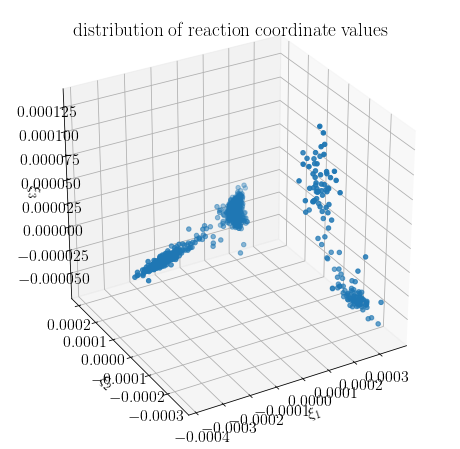

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xi[:,0], xi[:,1], xi[:,2])

plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 16}
plt.rc('font', **font)
ax.set_xlabel(r'$\xi_1$')
ax.set_ylabel(r'$\xi_2$')
ax.set_zlabel(r'$\xi_3$')
ax.set_title(r'distribution of reaction coordinate values')
ax.view_init(30, 240)

fig.set_size_inches(8,8)

plt.show()

When plotting the reaction coordinate values in the space of the two essential dihedral angles, one sees that the four clusters correspond to the four conformations, and that the traces correspond to the transition regions. This confirms that our reaction coordinate can resolve the transitions between the four conformations.

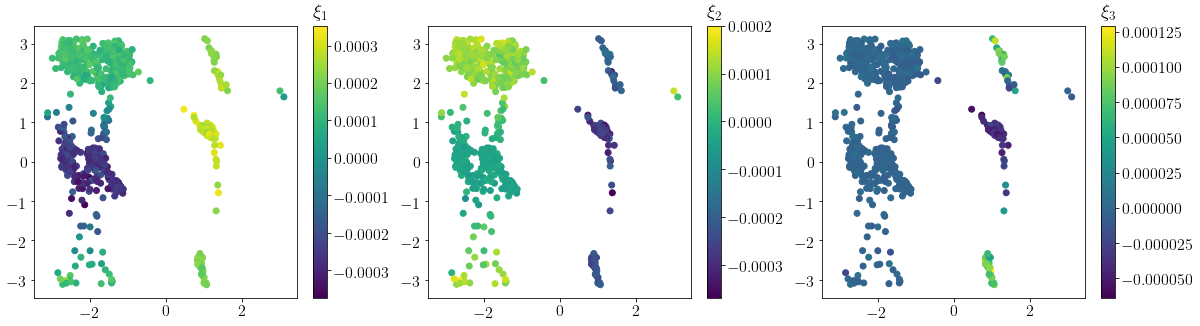

In [9]:
fig = plt.figure()

ax = fig.add_subplot(131)
sct = ax.scatter(phi,psi, c=xi[:,0], marker='o')
clb = fig.colorbar(sct)
clb.ax.set_title(r'$\xi_1$')

ax = fig.add_subplot(132)
sct = ax.scatter(phi,psi, c=xi[:,1], marker='o')
clb = fig.colorbar(sct)
clb.ax.set_title(r'$\xi_2$')

ax = fig.add_subplot(133)
sct = ax.scatter(phi,psi, c=xi[:,2], marker='o')
clb = fig.colorbar(sct)
clb.ax.set_title(r'$\xi_3$')

fig.set_size_inches(20,5)
plt.show()